<a href="https://colab.research.google.com/github/Luiz-Octavioo/Curso-de-Python-para-Estudos-Climaticos/blob/main/Xarray_para_estudos_climatico_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o Ambiente 

In [ ]:
# Instalar os pacotes
!echo 'Instalando as bibliotecas necessária para o ambiente.'
!pip install -q salem
!pip install -q pyproj
!pip install -q esmtools
!pip install -q numba==0.52
!pip install -q geopandas
!pip install -q rasterio
!echo 'Reiniciando o Ambiente para concluir a Instalação'
exit()

Reiniciando o Ambiente para concluir a Instalação


<center> <img src=https://repository-images.githubusercontent.com/13221727/f43c8900-75c0-11ea-9e1b-66b0af0689e0 width=45% height=125%> <center>

---------------------------------------------

## Importando as bibliotecas necessárias 

In [ ]:
import xarray as xr # Manipulação dos dados climaticos
import numpy as np 
import pandas as pd
import glob # criar listas por um determinado padrão
import os # biblioteca que acessa o sistema operacional
import salem # biblioteca para fazer o clip
from esmtools.grid import convert_lon # Utilidades
import matplotlib.pyplot as plt # Graficos

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Concatenar Datasets

Por muitas vezes, não encontramos os bancos de dados disponiveis na internet da exata maneira que precisamos para trabalhar.

Encontramos arquivos separados por ano, meses, dias, etc...

Neste contexto é interessante utilzarmos técnicas de manipulação destes dados para organizarmos da forma que precisamos

* **Neste exemplo vamos criar uma lista com os caminhos e nomes dos arquivos netcdf seguindo uma sequencia lógica de tempo**

    Neste caso, vamos utilizar a biblioteca **glob** para selecionarmos os arquivos em um diretorio por um determinado padrão.
    
Antes disso vamos listar os arquivos presentes no nosso diretório atual através da biblioteca os !!

In [ ]:
# Verificar o diretório atual 
print('O diretório atual é: ', os.getcwd())

O diretório atual é:  /content


In [ ]:
# Listar os arquivos presentes no diretório
os.listdir()

['.config',
 'precip.2021.nc',
 'sst.mnmean.nc',
 'precip.2018.nc',
 'tmax.2021.nc',
 'brazilian_legal_amazon.prj',
 'tmin.2021.nc',
 'brazilian_legal_amazon.shp',
 'precip.2019.nc',
 'brazilian_legal_amazon.cpg',
 'brazilian_legal_amazon.shx',
 'precip.2020.nc',
 'Correlação_prec_temp.nc',
 'brazilian_legal_amazon.dbf',
 'sample_data']

Queremos utilzar os arquivos **'precip.2018.nc', 'precip.2019.nc', 'precip.2020.nc', 'precip.2021.nc'**

In [ ]:
# Criar lista com os netcdfs
ncs = glob.glob('precip*')
ncs.sort()
ncs

['precip.2018.nc', 'precip.2019.nc', 'precip.2020.nc', 'precip.2021.nc']

* Utilizar a funçao **`.open_mfdataset`** para concatenar os arquivos netcdfs e abri-los como um unico arquivo 

In [ ]:
# Abrir o banco de dados
ds = xr.open_mfdataset(ncs).sel(lat=slice(12, -60), lon=slice(275, 330))

In [ ]:
# Abrir o dataset
ds

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 110, time: 1461)
Coordinates:
  * lat      (lat) float32 11.75 11.25 10.75 10.25 ... -58.75 -59.25 -59.75
  * lon      (lon) float32 275.2 275.8 276.2 276.8 ... 328.2 328.8 329.2 329.8
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2021-12-31
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(365, 144, 110), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0 RT
    dataset_title:  CPC GLOBAL PRCP V1.0
    dataset:        CPC Global Precipitation
    history:        Updated 2019-01-28 17:33:20
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...

## Fazer a leitura de um shapefile para posteriomente o fazer um recorte (CLIP)

Vamos usar a funcão **`.read_shapefile`** da biblioteca **salem** que utiliza funções do geopandas. 

In [ ]:
# ler o shapefile da amazonia legal
path = 'brazilian_legal_amazon.shp'
amazon = salem.read_shapefile(path)
# Verificando o shapefile
amazon

,SPRAREA,SPRPERIMET,SPRCLASSE,geometry,min_x,max_x,min_y,max_y
0,5.068004e+12,1.877763e+07,AM_Legal,"POLYGON ((-44.04149 -2.46528, -43.95183 -6.754...",-73.990972,-43.951827,-18.041767,5.272225


* **Antes de fazermos o clip do dataset pelo shapefile devemos observar a orientação das dimensões.**
* **Neste caso a dimensão de longitude apresenta o formade de 0 a 360. Portanto devemos converte-la para o formato de -180 a 180**

Desta maneira não haverá problemas em fazer o clip

Para tal, vamos utilizar a função **``convert_lon``** da biblioteca **esmtools**  para fazer a conversao da longitude

In [ ]:
# Converter a longitude do dataset para o formato de -180 a 180
ds = convert_lon(ds, coord='lon')
ds

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 110, time: 1461)
Coordinates:
  * lat      (lat) float32 11.75 11.25 10.75 10.25 ... -58.75 -59.25 -59.75
  * lon      (lon) float32 -84.75 -84.25 -83.75 -83.25 ... -31.25 -30.75 -30.25
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2021-12-31
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(365, 144, 110), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0 RT
    dataset_title:  CPC GLOBAL PRCP V1.0
    dataset:        CPC Global Precipitation
    history:        Updated 2019-01-28 17:33:20
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...

In [ ]:
# Recorte
# Recortar o arquivo netcdf pelo shapefile
ds_amazon = ds.salem.subset(shape=amazon, margin=2)
ds_amazon = ds_amazon.salem.roi(shape=amazon)

## Convertendo o formato de dados diarios para uma soma mensal

vamos fazer esta operação utilizando o método **``.resample``**

In [ ]:
ds_mensal = ds_amazon.resample({'time':'1MS'}).sum(dim='time')#.compute()

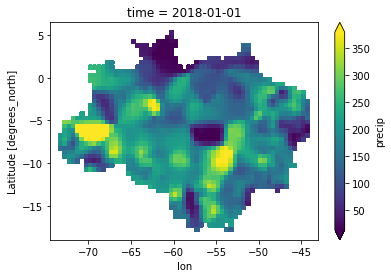

In [ ]:
ds_mensal.precip.isel(time=0).where(ds_mensal.precip.isel(time=0) > 0).plot(robust=True)

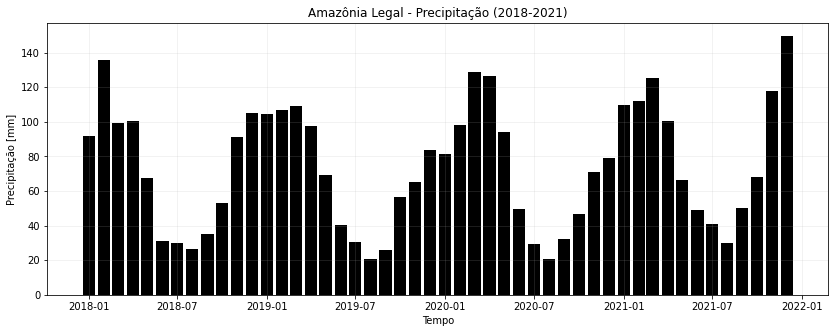

In [ ]:
# Verificar a série temporal utilizando métodos de plotagem do xarray
fig, ax = plt.subplots(figsize=(14, 5))
prec = ds_mensal.precip.mean(dim=['lat', 'lon']).to_series()
ax.bar(prec.index, prec.values, width=25, color='black')
ax.set_ylabel('Precipitação [mm]')
ax.set_xlabel('Tempo')
ax.set_title('Amazônia Legal - Precipitação (2018-2021)')
# ax.set_xticks(np.arange(0, 48+1, 4))
ax.grid(alpha=0.2)

# Analise da Temperatura do Oceano (TSM)

In [ ]:
# Abrir o dataset com os dados de temperatura da superficie do mar
sst = xr.open_dataset('sst.mnmean.nc')

In [ ]:
sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2017)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-02-04

# Calculo das anomalias da temperatura da superficie do oceano

* Primeiro devemos calcular a climatologia (30 anos) para as TSM

In [ ]:
# Recorte temporal para o calculo das anomalias (30 anos)
ds_slice = sst.sel(time=slice('1981-01-01', '2010-12-01'))
clim = ds_slice.groupby('time.month').mean(dim='time')

In [ ]:
# Verificar a climatologia
clim

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, month: 12, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (month, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

* Agora calculamos as anomalias de TSM

In [ ]:
# Calculo
asst = (sst.groupby('time.month') - clim)

In [ ]:
asst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2017)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-01-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 -4.768e-07 -4.768e-07 ... nan nan

In [ ]:
# asst.sst.sel(time='1997-10-01').plot(vmin=-2.5, vmax=2.5, center=0, extend='both', cmap='RdBu_r')

<center><img src=https://www.researchgate.net/profile/Janeet-Sanabria/publication/328685089/figure/fig4/AS:688348431659008@1541126463474/Location-of-the-Nino-regions-for-measuring-Sea-Surface-Temperature-SST-in-the-eastern.ppm width=70% heigth=75%></center>

## Calculo da Anomalia na região de Niño 3.4

* **Vamos fazer um recorte na area definida de Nino 3.4**

In [ ]:
# Fazer um recorte para obter uma serie temporal da Região Nino 3.4
asst_slice = asst.sel(time=slice('1981-01-01','2021-12-01'))
nino_34 = asst_slice.sel(lon=slice(190, 240), lat=slice(5,-5))

In [ ]:
nino_34

<xarray.Dataset>
Dimensions:    (lat: 5, lon: 26, nbnds: 2, time: 492)
Coordinates:
  * lat        (lat) float32 4.0 2.0 0.0 -2.0 -4.0
  * lon        (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 -0.05313 -0.05188 ... -1.191 -1.243

* **Plot da area recortada para simples visualização**

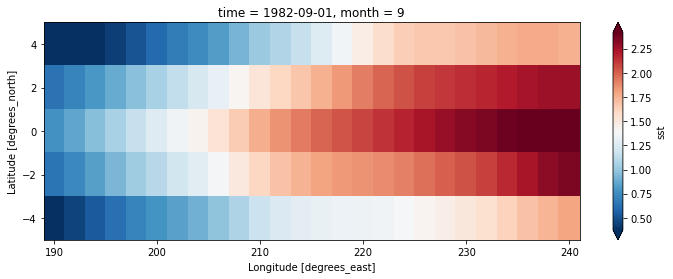

In [ ]:
nino_34.sst.isel(time=20).plot(robust=True, cmap='RdBu_r', figsize=(12, 4))

* **Após o recorte podemos reduzir essas imagens para uma série de temporal com o cálculo da média considerando todos os pixels presentes na area**

In [ ]:
# Reduzir para série temporal 
nino34_avg = nino_34.mean(dim=['lat','lon'])

In [ ]:
# Transformar em dataframe para o plot
nino_df = nino34_avg.to_dataframe().reset_index()
nino_df.set_index('time', inplace=True)

* **Plot das Anomalias no setor 3.4**

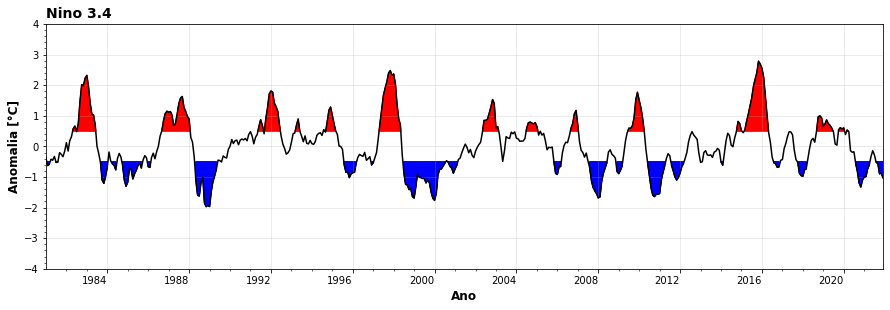

In [ ]:
# PLOT ANOMALIAS NINO 3.4
fig, ax = plt.subplots(figsize=(15, 5))

el_nino_threshold = 0.5
y = nino_df.sst

# Plot da série temporal
nino_df.sst.plot(color='black', ax=ax, rot=0)

# Plot de preenchimento
# EL Nino
ax.fill_between(nino_df.index, el_nino_threshold, y, color='red',
                 where=y>=el_nino_threshold, interpolate=True)
# La Nina
ax.fill_between(nino_df.index, -el_nino_threshold, y, color='blue',
                 where=y<=-el_nino_threshold)


# Configurar os limites dos eixos
x_limits = [min(nino_df.index), max(nino_df.index)]
y_limits = [-4, 4]

# Definir os limites do eixo x
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)


### Ticks 
###### OPCIONAL
ax.minorticks_on()
ax.set_ylabel("Anomalia [°C]", fontweight='bold', fontsize=12)
ax.set_xlabel("Ano", fontweight='bold', fontsize=12)
ax.set_title('Nino 3.4',loc='left' ,fontweight='bold', fontsize=14)
ax.grid(alpha=0.3)

### Calcular o ONI

Para calcular o ONI devemos utilizar devemos aplicar um calculo de média móvel considerando 3 meses 

In [ ]:
# Verificando o arquivo com a média 
nino34_avg

<xarray.Dataset>
Dimensions:    (nbnds: 2, time: 492)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time) float32 -0.3695 -0.6286 -0.5853 ... -0.8988 -0.8666 -1.027

In [ ]:
# Calculando o ONI
oni = nino34_avg.rolling(time=3).mean(dim='time') # média móvel de 3 meses

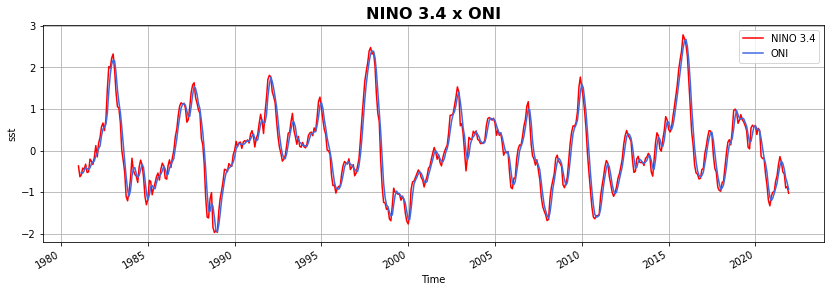

In [ ]:
# PLot simples
fig, ax = plt.subplots(figsize=(14, 4))
nino34_avg.sst.plot(label='NINO 3.4', color='red')
oni.sst.plot(label='ONI', color='royalblue')
ax.set_title('NINO 3.4 x ONI', fontdict=dict(fontweight='bold', fontsize=16))
ax.grid()
ax.legend()

* **Criar um array categórico**

In [ ]:
# Remover variavel desnecessária
oni = oni.drop_vars('time_bnds')

In [ ]:
# Xarray categorico
nino34 = xr.full_like(oni.sst, 'neutral', dtype='U7')
nino34[oni.sst >= 0.5] = 'nino'
nino34[oni.sst <= -0.5] = 'nina'
nino34

<xarray.DataArray 'sst' (time: 492)>
array(['neutral', 'neutral', 'nina', 'nina', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'neutral', 'neutral',
       'nina', 'nina', 'nina', 'nina', 'nina', 'neutral', 'neutral',
       'nina', 'nina', 'nina', 'neutral', 'neutral', 'neutral', 'nina',
       'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina',
       'nina', 'nina', 'nina', 'neutral', 'neutral', 'neutral', 'nina',
       'nina', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino',
       'nino', 'nino', 'neutral', 'neutral', 'neutral', 'nina', 'nina',
       'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina',
       'nina', 'nina', 'nina', 'nina', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'nino', 'nino', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino',
...
       'nina', 'nina', 'nina', 'nina', 'neutral', 'neutral', 'neutral',
       'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'nino', 'nino', 'nino', 'nino', 'neutral', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'neutral', 'neutral', 'neutral',
       'nina', 'nina', 'nina', 'nina', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'nino', 'nino', 'nino',
       'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'nino', 'neutral',
       'neutral', 'neutral', 'neutral', 'nino', 'nino', 'nino', 'nino',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'nina',
       'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina', 'nina',
       'neutral', 'neutral', 'neutral', 'neutral', 'nina', 'nina', 'nina'],
      dtype='<U7')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
sst_nino_composite = asst_slice.groupby(nino34.rename('nino34')).mean(dim='time')

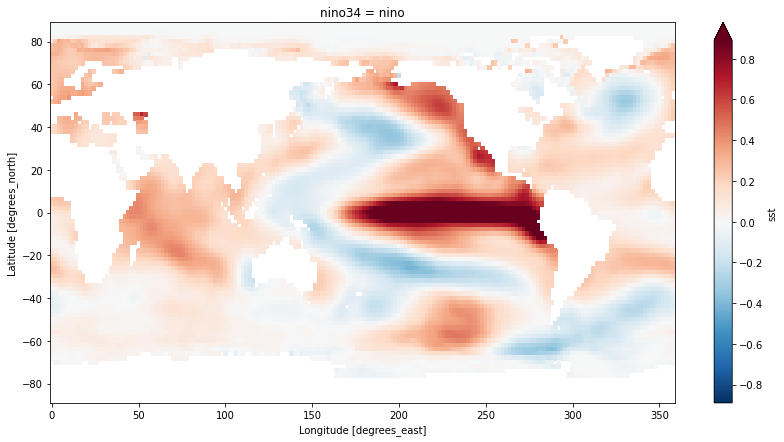

In [ ]:
sst_nino_composite.sst.sel(nino34='nino').plot(robust=True, figsize=(14,7))

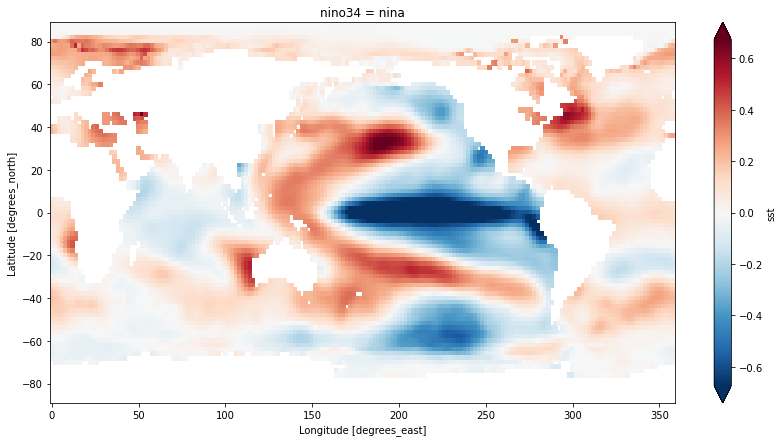

In [ ]:
sst_nino_composite.sst.sel(nino34='nina').plot(robust=True, figsize=(14,7))

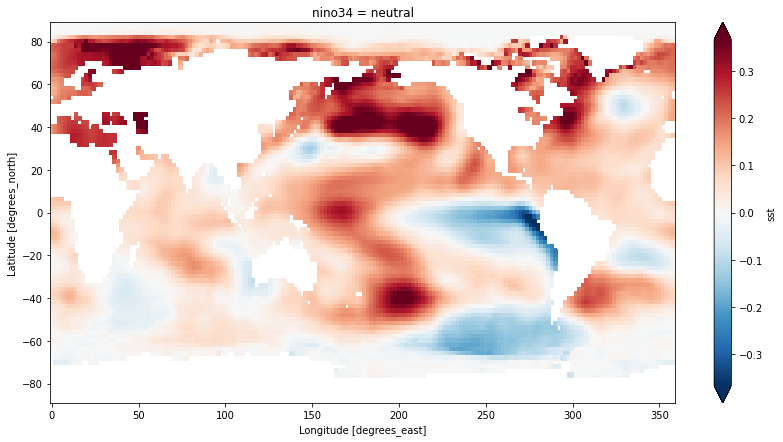

In [ ]:
sst_nino_composite.sst.sel(nino34='neutral').plot(robust=True, figsize=(14,7))

source: 

In [ ]:
# # Criar um novo dataarray xarray
# nino_ds = xr.Dataset({'nino34': nino34, 'oni': oni.sst}).drop('month')

# Correlação entre datasets

In [ ]:
from esmtools.stats import corr

In [ ]:
tmax = xr.open_dataset('tmax.2021.nc')
tmin = xr.open_dataset('tmin.2021.nc')
precip = xr.open_dataset('precip.2021.nc')

In [ ]:
tmean = ((tmax.tmax + tmin.tmin)/2)

In [ ]:
cor, sig = corr(x=tmean, y=precip.precip, dim='time', return_p=True)

Text(0.5, 1.0, 'Correlação de Pearson R entre a Temperatura média do Ar com a Precipitação')

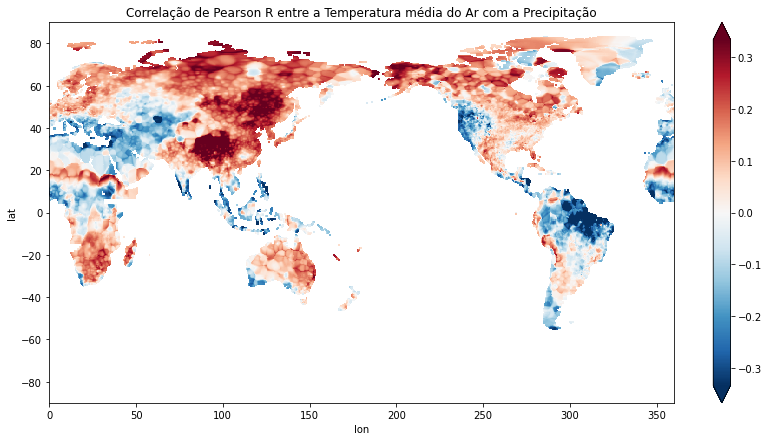

In [ ]:
cor.plot(robust=True, figsize=(14,7))
plt.title('Correlação de Pearson R entre a Temperatura média do Ar com a Precipitação')

Text(0.5, 1.0, 'Signficancia da Correlação de Pearson R - Valor-p')

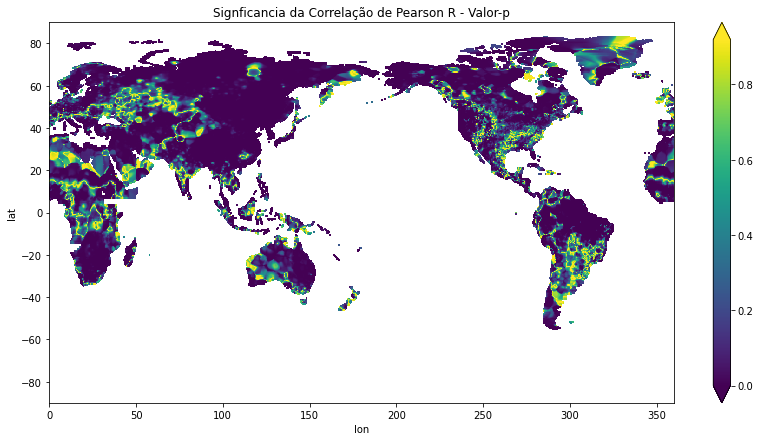

In [ ]:
sig.plot(robust=True, figsize=(14,7))
plt.title('Signficancia da Correlação de Pearson R - Valor-p')

In [ ]:
# Salvar o Dataset com a Correlação
cor.to_netcdf('Correlação_prec_temp.nc')